# 벽돌 데이터 수집

## 코드 설계

 IMAGE --> grayscale --> threshold--> erode --> find contour --> cut --> normalization

## 파일 불러오기 및 준비

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# generator 객체를 반환.
def readFiles(path, opener=cv2.imread):
    filepath_list = []
    file_list = []

    if not os.path.isdir(path):
        raise Exception(f"'{path}' is not a directory.")

    for f in os.listdir(path):
        filepath = os.path.join(path, f)

        if os.path.isfile(filepath):
            opened = opener(filepath)
            if (type(opened) == type(None)) : continue

            filepath_list.append(filepath)
            file_list.append(opened)

    return filepath_list, file_list

## plot에서 한글이 출력 안되는 문제 해결

In [2]:
import matplotlib.font_manager as fm

korean_font = fm.FontProperties(fname='/System/Library/Fonts/AppleSDGothicNeo.ttc', size=14)

## 파손 침식 등을 검출

In [3]:
def findHoles(frame_bgr):
    frame_hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
    # 채도(S)와 밝기(V)가 낮은 영역 : 검은색 영역을 선택
    frame_bin = cv2.inRange(frame_hsv, (  0,  0,  0), (255, 96, 96))
    frame_bin = cv2.morphologyEx(frame_bin, cv2.MORPH_OPEN, (5,5))
    return frame_bin

def findContoursFromMask(frame_color, mask, area_thresh=32):
    contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

    frame_cut_list = []
    box_list = []

    for cont in contours:
        if cv2.contourArea(cont) < area_thresh: continue

        x, y, w, h = cv2.boundingRect(cont)
        cx, cy = x + w/2, y + h/2
        n = max(w,h)
        
        x0, y0 = int(cx - n/2), int(cy - n/2)
        x1, y1 = int(cx + n/2), int(cy + n/2)
        
        frame_cut = np.zeros((n,n,3), dtype=np.uint8)
        frame_cut = frame_color[y0:y1, x0:x1]
        
        if not frame_cut.any(): continue

        frame_cut_list.append(frame_cut.copy())
        box_list.append((x,y,w,h))

    return frame_cut_list, box_list

## 결과 출력

From file './res/total_01.JPG':


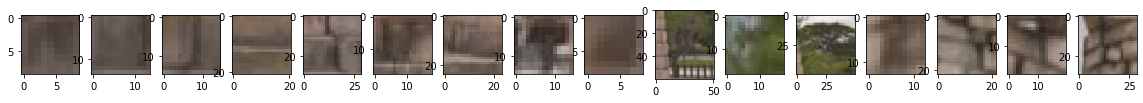

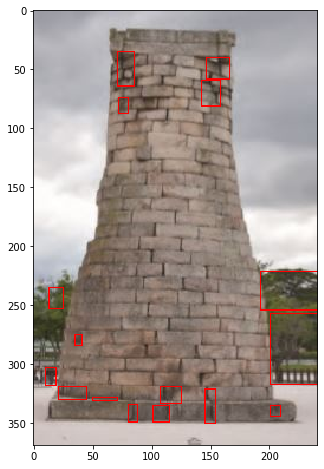

From file './res/partial_01.JPG':


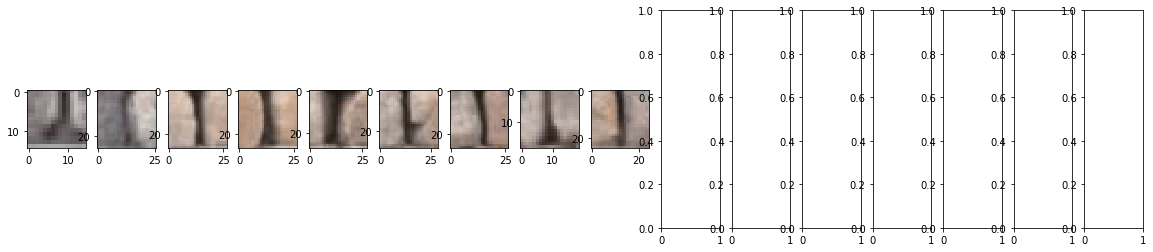

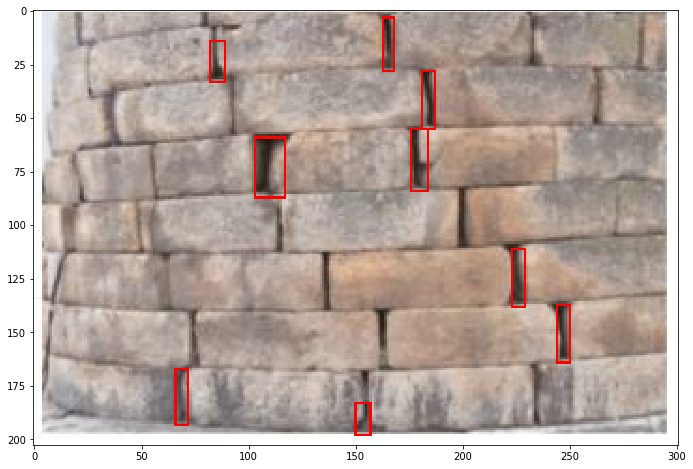

From file './res/partial_p_01.JPG':


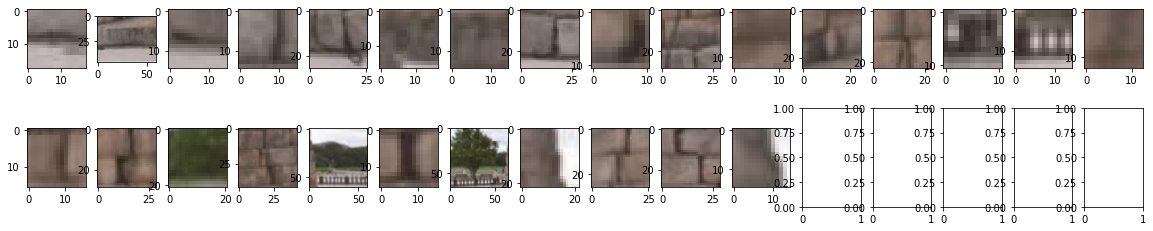

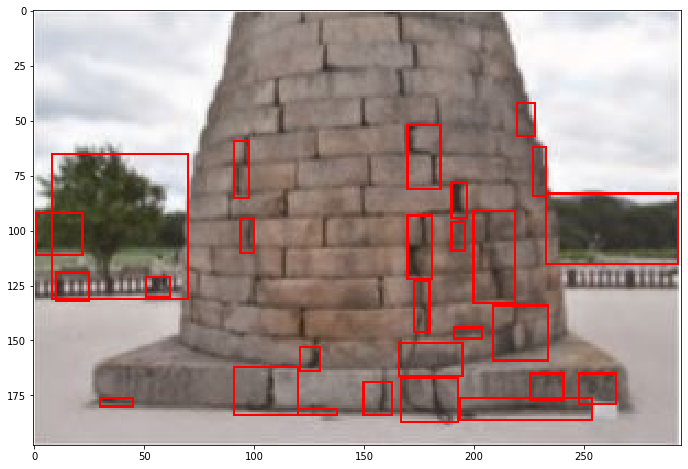

In [4]:
file_path_list, frame_list = readFiles('./res/', opener=cv2.imread)

for file_path, frame_bgr in zip(file_path_list, frame_list): 
    if (type(frame_bgr) == type(None)) : continue

    print(f"From file '{file_path}':")

    mask = findHoles(frame_bgr)
    frame_cut_list, box_list = findContoursFromMask(frame_bgr, mask, area_thresh=20)
    idx_list = range(len(frame_cut_list))

    # Plotting
    cells_per_line = 16
    hor_cells = cells_per_line
    ver_cells = 1+(len(frame_cut_list)-1)//cells_per_line

    sub_fig, sub_axes = plt.subplots(ver_cells, hor_cells, figsize=(20,4))

    for frame_cut, box, idx in zip(frame_cut_list, box_list, idx_list):
        # Save files & Draw Bounding Boxes
        x,y,w,h = box
        cv2.rectangle(frame_bgr, (x,y), (x+w,y+h), (0,0,255), 1)

        cv2.imwrite(f'./out/{os.path.basename(file_path)}_{idx}.png', frame_cut)

        # Plotting
        _ax = sub_axes[idx%cells_per_line] if ver_cells == 1 else sub_axes[idx//cells_per_line][idx%cells_per_line]
        _ax.imshow(cv2.cvtColor(frame_cut, cv2.COLOR_BGR2RGB))
    plt.show()

    # Plot image with bounding boxes
    fig, ax = plt.subplots(1,1, figsize=(20,8))
    ax.imshow(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
    plt.show()